# Lotka Volterra 

This is an influential model in ecology describing the dynamics of two interacting species, most commonly prey
and predator interactions. Our task consists in the inference of four parameters $\theta = \{\alpha, \beta, \gamma, \delta\}$ related to species interaction, given 20 summary statistics consisting of the number of individuals in both populations in 10 evenly-spaced
points in time.

The Lotka-Volterra (aka Prey-Predator) model is a model that describes the evolution of the population of two species (e.g. foxes and rabbits):

$\frac{du}{dt} =\alpha u - \beta uv $  

$\frac{dv}{dt} = -\gamma v + \delta buv $

- u(t) population size of the prey species (rabbits)
- v(t) population size of the predator species (foxes)

$\alpha, \beta, \gamma, \delta \geq 0$
- $\alpha$  prey growth/reproduction rate
- $\beta$ prey shrinkage/death rate
- $\gamma$ predator shrinakge/death rate
- $\delta$ predators born per prey

In [1]:
#See also https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html
#
%load_ext autoreload
%autoreload 2

In [2]:
import sbi
sbi.__version__

'0.17.2'

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import numpy as np

import sbibm
from sbibm.algorithms import snpe
from sbibm.metrics import c2st
from sbi.analysis import pairplot, marginal_plot

from loss_calibration.classifier import FeedforwardNN, train
from loss_calibration.lotka_volterra import posterior_ratio_given_samples, plot_observations, load_data, generate_data
from loss_calibration.npe import train_npe
from loss_calibration.loss import StepLoss_weighted, LinearLoss_weighted
from loss_calibration.utils import prepare_for_training, save_metadata, format_axis


## Task, Prior, Simulator

Use implementation provided by sbibm.

In [4]:
task = sbibm.get_task('lotka_volterra')

In [5]:
print(task.dim_data,              # dimensionality data, here: 20
      task.dim_parameters,        # dimensionality parameters, here: 4
      task.num_observations)      # number of different observations x_o available, here: 10

20 4 10


Take a look at the observations

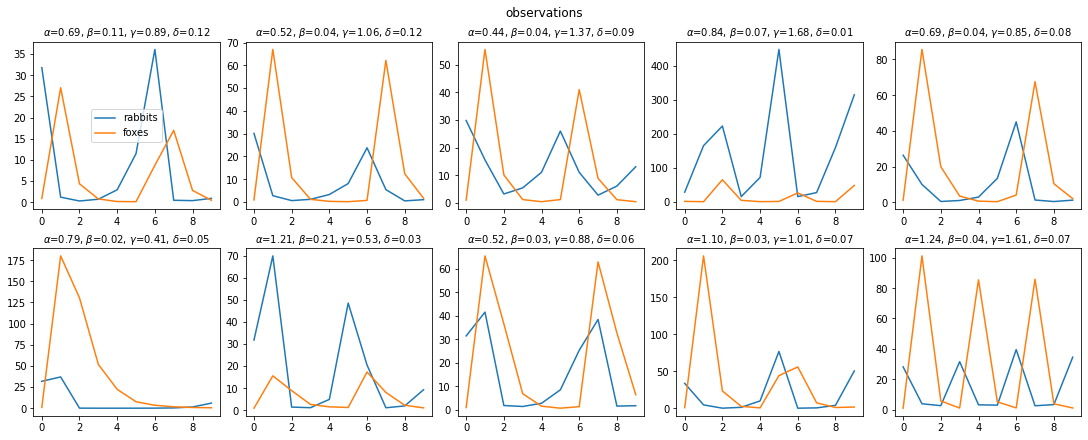

In [6]:
plot_observations(2,5)

Check out prior

In [7]:
# priors defined as Log Normal with 
mu_p1 = -0.125
mu_p2 = -3.0
sigma_p = 0.5

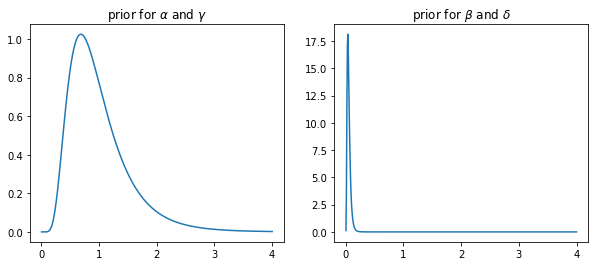

In [8]:
ths  = torch.linspace(0,4, 500)
log_normal1 = torch.distributions.LogNormal(mu_p1, sigma_p)
log_normal2 = torch.distributions.LogNormal(mu_p2, sigma_p)

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(ths, torch.exp(log_normal1.log_prob(ths)))
axes[0].set_title(r'prior for $\alpha$ and $\gamma$')
axes[1].plot(ths, torch.exp(log_normal2.log_prob(ths)))
axes[1].set_title(r'prior for $\beta$ and $\delta$')
plt.show()

Simulator is given by ODE described above

## True Posterior

given by reference samples for each observation

## Generate training data $(\theta, x) \sim p(\theta)p(x|\theta)$

In [10]:
load = True
if load: 
   theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data()
else: 
   theta_train, x_train, theta_val, x_val, theta_test, x_test = generate_data(save_data=False)

Load data from './data/lotka_volterra'.


## NPE

In [ ]:
reference_samples = [task.get_reference_posterior_samples(num_observation=n+1) for n in range(10)]

num_samples=5000
num_sim = 100_000

train_posterior = False
if train_posterior:  
    # since NPE is amoritzed, return the posterior and use it for all observations
    npe_posterior = train_npe(theta_train, x_train, num_observation=1)
    torch.save(npe_posterior, f"./results/lotka_volterra/npe_posterior_sim{num_sim//1000}k.pt")
else: 
    npe_posterior = torch.load(f"./results/lotka_volterra/npe_posterior_sim{num_sim//1000}k.pt")

In [ ]:
num_samples = 10000
npe_samples = []
for n in range(10):
    samples = npe_posterior.sample((num_samples,), x = task.get_observation(n+1))
    npe_samples.append(samples)

In [ ]:
#c2st_accuracy = c2st(reference_samples[0], npe_samples[0])
#c2st_accuracy

### Pairplots

In [ ]:
for obs in range(1,11):
    print('observation', obs)
    limits = [[0.2, 1.75], [0.0, 0.25], [0.25, 3.5], [0.0, 0.2]]
    limit_dict = {"1": [[0.5, 1.0], [0.05, 0.2], [0.5, 1.25], [0.075, 0.2]],
                  "2": [[0.4, 0.8], [0.025, 0.075], [0.5, 1.5], [0.075, 0.15]],
                  "3": [[0.3, 0.6], [0.025, 0.07], [1.0, 1.75], [0.075, 0.125]],
                  "4": [[0.6, 1.0], [0.0, 0.1], [1.5, 3.5], [0.0, 0.04]],
                  "5": [[0.4, 1.0], [0.025, 0.075], [0.5, 1.25], [0.05, 0.1]],
                  "6": [[0.2, 1.5], [0.0, 0.05], [0.2, 0.6], [0.025, 0.075]],
                  "7": [[0.9, 1.5], [0.15, 0.25], [0.45, 0.65], [0.02, 0.04]],
                  "8": [[0.4, 0.75], [0.02, 0.05], [0.6, 1.0], [0.04, 0.075]],
                  "9": [[0.9, 1.25], [0.02, 0.04], [0.9, 1.2], [0.05, 0.1]],
                  "10": [[1.0, 1.75], [0.025, 0.075], [1.0, 2.0], [0.025, 0.125]],}
    #limits = limit_dict[str(obs)]
    labels=[r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
    dims = 4 
    rows = 4
    cols = 9
    fig, axes = plt.subplots(rows,cols,figsize=(27,12))
    fig.suptitle(f'Observation {obs}')
    axes[0,2].set_title('NPE')
    axes[0,7].set_title('true posterior')
    for r in range(rows):
        for c in range(cols):
            # diagonals
            if r==c: 
                format_axis(axes[r,c], xhide=False, xlabel=labels[c], yhide=True,)
                format_axis(axes[r,c+dims+1], xhide=False, xlabel=labels[c], yhide=True,)
                axes[r,c].hist(npe_samples[obs-1][:,c%dims], bins=50, range=[limits[r][0], limits[r][1]])
                axes[r,c].set_xlim((limits[c][0], limits[c][1]))
                axes[r,c+dims+1].hist(reference_samples[obs-1][:,c%dims], bins=50, range=[limits[r][0], limits[r][1]])
                axes[r,c+dims+1].set_xlim((limits[c][0], limits[c][1]))
            elif (c == 4) or (r>c) or (r>(c%5)): 
                axes[r,c].axis("off")
                continue
            # off-diagonals
            # NPE
            elif c < 4:
                format_axis(axes[r,c], xhide=True, yhide=True,)
                hist, xedges, yedges = np.histogram2d(npe_samples[obs-1][:,c%dims].numpy(), 
                                                    npe_samples[obs-1][:,r%dims].numpy(), 
                                                    bins=100, 
                                                    range=[[limits[c][0], limits[c][1]],[limits[r][0], limits[r][1]],],)
                axes[r,c].imshow(hist.T, origin="lower", extent=[xedges[0],xedges[-1],yedges[0],yedges[-1],], aspect="auto",)
            # True posterior
            elif c > 4 and not r==((c-1)%dims):
                format_axis(axes[r,c], xhide=True, yhide=True,)
                hist, xedges, yedges = np.histogram2d(reference_samples[obs-1][:,(c-1)%dims].numpy(),
                                                    reference_samples[obs-1][:,r%dims].numpy(), 
                                                    bins=100, 
                                                    range=[[limits[(c-1)%dims][0], limits[(c-1)%dims][1]],[limits[r][0], limits[r][1]],],)
                axes[r,c].imshow(hist.T, origin="lower", extent=[xedges[0],xedges[-1],yedges[0],yedges[-1],], aspect="auto",)
    fig.savefig(f'./results/lotka_volterra/npe_vs_true/npe_vs_true_obs{obs}.pdf')
    fig.savefig(f'./results/lotka_volterra/npe_vs_true/npe_vs_true_obs{obs}.jpg')
    plt.show()

### Marginal Plots

In [ ]:
for obs in range(1,11):
    limit_dict = {"1": [[0.5, 1.0], [0.05, 0.2], [0.5, 1.25], [0.075, 0.2]],
                  "2": [[0.4, 0.8], [0.025, 0.075], [0.5, 1.5], [0.075, 0.15]],
                  "3": [[0.3, 0.6], [0.025, 0.07], [1.0, 1.75], [0.075, 0.125]],
                  "4": [[0.6, 1.0], [0.0, 0.1], [1.5, 3.5], [0.0, 0.04]],
                  "5": [[0.4, 1.0], [0.025, 0.075], [0.5, 1.25], [0.05, 0.1]],
                  "6": [[0.2, 1.5], [0.0, 0.05], [0.2, 0.6], [0.025, 0.075]],
                  "7": [[0.9, 1.5], [0.15, 0.25], [0.45, 0.65], [0.02, 0.04]],
                  "8": [[0.4, 0.75], [0.02, 0.05], [0.6, 1.0], [0.04, 0.075]],
                  "9": [[0.9, 1.25], [0.02, 0.04], [0.9, 1.2], [0.05, 0.1]],
                  "10": [[1.0, 1.75], [0.025, 0.075], [1.0, 2.0], [0.025, 0.125]],}
    limits = limit_dict[str(obs)]
    limits = [[0.25, 1.65], [0.01, 0.25], [0.3, 3.5], [0.01, 0.14]]
    marginal_plot([reference_samples[obs-1], npe_samples[obs-1]], limits=limits, figsize=(16,4), title=f'Observation {obs}', labels=[r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$'], legend=True, labels_samples=['true', 'npe'])
    #plt.savefig(f'./results/lotka_volterra/marginal_plots/marginal_plot_obs{obs}.jpg')

## Classifier

### Decision Based on NPE Marginal Plots

To see wether the classifier approach works for Lotka Volterra, we explicitly set the treshold and costs such that NPE breaks, i.e. makes the wrong direction for specific observations. 

#### Observation 7 - $\beta=0.18$

In [ ]:
obs = 7
marginal_plot([reference_samples[obs-1], npe_samples[obs-1], theta_train], #theta_train[torch.logical_and(theta_train[:, 1] > reference_samples[obs-1][:,1].min(),theta_train[:, 1] < reference_samples[obs-1][:,1].max())]],
              #limits=limit_dict[str(obs)],
              figsize=(16,4), 
              title=f'Observation {obs}', 
              labels=[r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$'], 
              legend=True,
              labels_samples=['true', 'npe', 'train'])
plt.show()

In [ ]:
# take beta for decisions
T_beta = 0.18
costs = [20.,1.]

In [ ]:
step_loss = StepLoss_weighted(costs, T_beta)

fig, ax = plt.subplots(2,1,figsize=(10,8), sharex=True)
ax[0].hist(reference_samples[6][:,1], bins=50, label='true')
ax[0].hist(npe_samples[6][:,1], bins = 50, label='npe')
ax[0].legend()
ax[0].set_xlim(0, 0.25)
betas = torch.linspace(0,0.25, 250)
ax[1].plot(betas.numpy(), step_loss(betas, 0), label = 'cost predicting 0')
ax[1].plot(betas.numpy(), step_loss(betas, 1), label = 'cost predicting 1')
ax[1].legend()
ax[1].set_xlim(0, 0.25)
plt.show()

Decisions taken when using the true posterior

Since we only have ten observations and their respective true posterior available, check out the correct decision for them: 

In [ ]:
posterior_ratios = []
npe_ratios = []
for n in range(1,11):
    posterior_obs_beta = reference_samples[n-1][:,1]
    posterior_ratio = posterior_ratio_given_samples(posterior_obs_beta, T_beta, costs)
    posterior_ratios.append(posterior_ratio)
    npe_obs_beta = npe_samples[n-1][:,1]
    npe_ratio = posterior_ratio_given_samples(npe_obs_beta, T_beta, costs)
    npe_ratios.append(npe_ratio)
    print(f"{n}:\ttrue posterior: {posterior_ratio>0.5}\tNPE: {npe_ratio>0.5}")

train classifier

In [ ]:
train_clf = False
if train_clf:
    clf = FeedforwardNN(20, [100, 100, 100], 1)

    clf, loss_values_train, loss_values_val = train(
        clf,
        x_train,
        theta_train[:,1:2],
        x_val,
        theta_val[:,1:2],
        costs,
        T_beta,
        learning_rate=0.001,
        max_num_epochs=5000,
        stop_after_epochs=50,
        model_dir=f"/Users/mgorecki/Documents/Studium/Master/5.Semester/Masterarbeit/loss-calibration/results/lotka_volterra/classifier_obs{obs}",
    )
    
    clf(task.get_observation(7))

#### treshold $\alpha=0.8$

In [ ]:
# take alpha for decisions
idx_treshold = 0
threshold = 0.8
costs = [20.,1.]

In [ ]:
step_loss = StepLoss_weighted(costs, threshold)

fig, ax = plt.subplots(1,1,figsize=(10,3), sharex=True)
alphas = torch.linspace(0.5,1, 250)
ax.plot(alphas.numpy(), step_loss(alphas, 0), label = 'cost predicting 0')
ax.plot(alphas.numpy(), step_loss(alphas, 1), label = 'cost predicting 1')
ax.legend()
plt.show()

Decisions taken when using the true posterior

Since we only have ten observations and their respective true posterior available, check out the correct decision for them: 

In [ ]:
posterior_ratios = []
npe_ratios = []
for n in range(1,11):
    posterior_obs_alpha = reference_samples[n-1][:,idx_treshold]
    posterior_ratio = posterior_ratio_given_samples(posterior_obs_alpha, threshold, costs)
    posterior_ratios.append(posterior_ratio)
    npe_obs_alpha = npe_samples[n-1][:,idx_treshold]
    npe_ratio = posterior_ratio_given_samples(npe_obs_alpha, threshold, costs)
    npe_ratios.append(npe_ratio)
    print(f"{n}:\ttrue posterior: {posterior_ratio>0.5}\tNPE: {npe_ratio>0.5}")
print(f"Accuracy NPE: {((torch.tensor(posterior_ratios)>0.5) == (torch.tensor(npe_ratios) > 0.5)).sum()/len(posterior_ratios):.2f}")

train classifier

In [ ]:
train_clf = False
if train_clf: 
    # architectures = [[50,50], [50,50,50], [100,100], [100,100,100]]
    seed = 123
    torch.manual_seed(seed)
    train_clf = True
    if train_clf:
        base_dir = './results/lotka_volterra/classifier_alpha'
        model_dir = prepare_for_training(base_dir,threshold, costs)
        clf = FeedforwardNN(20, [100, 100, 100], 1)
        save_metadata(model_dir, 20, [100,100,100], costs, threshold, seed, 0.001, x_train.shape[0])

        clf, loss_values_train, loss_values_val = train(
            clf,
            x_train,
            theta_train[:,idx_treshold: idx_treshold+1],
            x_val,
            theta_val[:,idx_treshold: idx_treshold+1],
            costs,
            threshold,
            learning_rate=0.001,
            max_num_epochs=5000,
            stop_after_epochs=100,
            model_dir=model_dir,
            seed=seed
        )
else:
    m = torch.load("./results/lotka_volterra/classifier_alpha/2022-06-25T11_05_03_t0_8_c20_1/best_model.pt", map_location='cpu')
    clf = FeedforwardNN(20, [100, 100, 100], 1)
    clf.load_state_dict(m['state_dict'])

In [ ]:
clf_predictions = []
for n in range(1,11):
    pred = clf(task.get_observation(n).squeeze()).detach().item()
    clf_predictions.append(pred)
    print(f"{n}:\ttrue posterior: {posterior_ratios[n-1]:.3f}\t{posterior_ratios[n-1]>0.5}\tNPE: {npe_ratios[n-1]>0.5}\tclf: {pred:.4f}\t {pred>0.5}")
print(f"Accuracy NPE: {((torch.tensor(posterior_ratios)>0.5) == (torch.tensor(npe_ratios) > 0.5)).sum()/len(posterior_ratios):.2f}")
print(f"Accuracy classifier: {((torch.tensor(posterior_ratios)>0.5) == (torch.tensor(clf_predictions) > 0.5)).sum()/len(posterior_ratios):.2f}")

#### Multiple tresholds

Test multiple threshold to check for superiority of classifier compared to NPE

In [ ]:
labels = ["alpha", "beta", "gamma", "delta"]
thresholds =  [#(0,0.5), (0,0.6), (0,0.7), 
               (0,0.8), (0,0.9), (0,1.0), 
               (1, 0.05), (1, 0.1), (1, 0.15), (1, 0.18), (1, 0.2), 
               (2, 1.0), (2, 1.5), (2, 2.0),
               (3, 0.03), (3, 0.05), (3, 0.075), (3, 0.1)]
costs = [20.,1.]

In [ ]:
dump = []
for (idx, T) in thresholds:
    print(idx, T)
    base_dir = './results/lotka_volterra/classifier_varying_T'
    model_dir = prepare_for_training(base_dir,T, costs)

    seed = 0
    lr = 0.001
    input_dim = 20
    hidden_dims = [100,100,100]
    save_metadata(model_dir, input_dim, hidden_dims, costs, (idx, T), seed, lr, x_train.shape[0])


    clf = FeedforwardNN(input_dim, hidden_dims, 1)
    
    clf, loss_values_train, loss_values_val = train(
        clf,
        x_train,
        theta_train[:,idx: idx+1],
        x_val,
        theta_val[:,idx: idx+1],
        costs,
        T,
        learning_rate=lr,
        max_num_epochs=5000,
        stop_after_epochs=100,
        model_dir=model_dir,
        seed=seed
    )
    # compute posterior ratios
    posterior_ratios = []
    npe_ratios = []
    clf_ratios = []
    print(f"treshold: {labels[idx]}={T}")
    for n in range(1,11):
        posterior_obs_alpha = reference_samples[n-1][:,idx]
        posterior_ratio = posterior_ratio_given_samples(posterior_obs_alpha, T, costs)
        posterior_ratios.append(posterior_ratio)
        npe_obs_alpha = posterior_samples[n-1][:,idx]
        npe_ratio = posterior_ratio_given_samples(npe_obs_alpha, T, costs)
        npe_ratios.append(npe_ratio)
        pred = clf(task.get_observation(n).squeeze()).detach().item()
        clf_ratios.append(pred)
        print(f"{n}:\ttrue posterior: {posterior_ratio:.3f}\t{posterior_ratio>0.5}\tNPE: {npe_ratio>0.5}\tclf: {pred:.3f}\t {pred>0.5}")
    print(f"Accuracy NPE: {((torch.tensor(posterior_ratios)>0.5) == (torch.tensor(npe_ratios) > 0.5)).sum()/len(posterior_ratios):.2f}")
    print(f"Accuracy classifier: {((torch.tensor(posterior_ratios)>0.5) == (torch.tensor(clf_ratios) > 0.5)).sum()/len(posterior_ratios):.2f}")
    dump.append([idx, T, posterior_ratios, npe_ratios, clf_ratios, clf])
    

#### Evaluation

In [ ]:
import glob
import os.path as path
from copy import deepcopy
device = "cpu"

# load classifiers
model_files = sorted(glob.glob(path.join("./results/lotka_volterra/classifier_varying_T/2022-07-11*", "best_model.pt")))

#metadata_file = path.join("./results/lotka_volterra/classifier_varying_T/*", "metadata.json")
#metadata = json.load(open(metadata_file))
model = FeedforwardNN(20, [100, 100, 100], 1)

print(f"Loading models:")
clfs = []

for file in model_files:
    model_ckp = torch.load(file, map_location=torch.device(device))
    model.load_state_dict(model_ckp["state_dict"])
    print(f"- {file},\t train_loss = {model_ckp['training_losses'][-1]:.3f},\t val_loss = {model_ckp['validation_losses'][-1]:.3f}")
    model.eval()
    clfs.append(deepcopy(model))

In [ ]:
for i, clf in enumerate(clfs):
    posterior_ratios = []
    npe_ratios = []
    clf_ratios = []
    # compute posterior ratios
    print(thresholds[i])
    idx, T = thresholds[i]
    for n in range(1,11):
        posterior_obs_alpha = reference_samples[n-1][:,idx]
        posterior_ratio = posterior_ratio_given_samples(posterior_obs_alpha, T, costs)
        posterior_ratios.append(posterior_ratio)
        npe_obs_alpha = posterior_samples[n-1][:,idx]
        npe_ratio = posterior_ratio_given_samples(npe_obs_alpha, T, costs)
        npe_ratios.append(npe_ratio)
        pred = clf(task.get_observation(n).squeeze()).detach().item()
        clf_ratios.append(pred)
        print(f"{n}:\ttrue posterior: {posterior_ratio:.3f}\t{posterior_ratio>0.5}\tNPE: {npe_ratio>0.5}\tclf: {pred:.3f}\t {pred>0.5}")
    print(f"Accuracy NPE: {((torch.tensor(posterior_ratios)>0.5) == (torch.tensor(npe_ratios) > 0.5)).sum()/len(posterior_ratios):.2f}")
    print(f"Accuracy classifier: {((torch.tensor(posterior_ratios)>0.5) == (torch.tensor(clf_ratios) > 0.5)).sum()/len(posterior_ratios):.2f}\n")

In [ ]:
(torch.tensor(posterior_ratios)>0.5)

In [ ]:
posterior_obs_alpha = reference_samples[0][:,0]
posterior_ratio = posterior_ratio_given_samples(posterior_obs_alpha, T, costs)

In [ ]:
posterior_obs_alpha

In [ ]:
posterior_ratio